In [1]:
from fit import *
from process_showers import ProcessCkv
from gen_ckv_signals import get_ckv
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_files
from counter_config import CounterConfig, init_config

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
# data_date_and_time = '20190504034237'
# data_files = get_data_files(data_date_and_time)
# noise_files = [preceding_noise_file(f) for f in data_files]
# cfg = CounterConfig(data_files, noise_files)
data_date_and_time = '20230618050455'
cfg = init_config(data_date_and_time)

Now let's simulate an event with given shower parameters.

In [3]:
# pars = [6.479052e+02,1.705156e+06,5.890362e-01,2.461860e+00, 437., -660.,-29.0,0,70,0.]
pars = [600.,2.e6,np.deg2rad(40.),np.deg2rad(200.), 450., -660.,-29,0,70,0.]
ev = BasicParams.get_event(pars)
pe = ProcessCkv(cfg, frozen_noise=True)
ckv = get_ckv(ev,cfg)

real_nfits = pe.gen_nfits_from_ckv(ckv)
print(ev)

Event(E=1538461538461538.5, Xmax=600.0, Nmax=2000000.0, zenith=0.6981317007977318, azimuth=3.490658503988659, corex=450.0, corey=-660.0, corez=-29, X0=0, Lambda=70)


We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

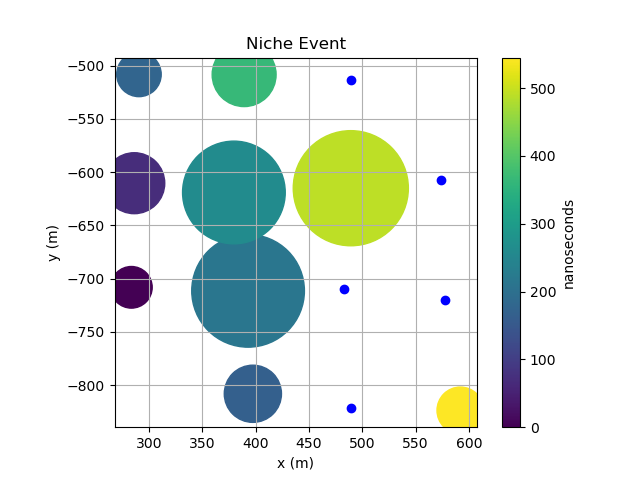

In [4]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [5]:
pf

20240829131312.000025393
bardeen bell curie newton noether rossi rubin rutherford wu 
nx = -0.6184 ny = -0.2148 z0 =   1.5
  +/- 0.0001   +/- 0.0001   +/-  0.0
  ( 4.25e-09 -9.93e-10 -1.53e-07)
  (-9.93e-10  4.45e-09 -1.91e-08)
  (-1.53e-07 -1.91e-08  2.12e-05)
th =  0.7136 ph =  3.4759

In [6]:
guess = make_guess(ty, pf,cfg)
# for i,p in enumerate(guess):
#     guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=500.0, limits=(400.0, 1000.0), error=50.0, fixed=False)
FitParam(name='nmax', value=1000000.0, limits=(10000.0, 10000000.0), error=100000.0, fixed=False)
FitParam(name='zenith', value=0.7136450295733823, limits=(0.0, 0.8136450295733823), error=0.017453292519943295, fixed=False)
FitParam(name='azimuth', value=3.4758869083089357, limits=(3.3758869083089356, 3.5758869083089357), error=0.017453292519943295, fixed=False)
FitParam(name='corex', value=420.44828523123624, limits=(379.5, 489.2), error=5.0, fixed=False)
FitParam(name='corey', value=-635.5347140463962, limits=(-711.4, -508.5), error=5.0, fixed=False)
FitParam(name='corez', value=-29.0, limits=(-29.0, -29.0), error=1.0, fixed=True)
FitParam(name='x0', value=0.0, limits=(-1000.0, 1000.0), error=1, fixed=True)
FitParam(name='lambda', value=70.0, limits=(40.0, 100.0), error=1, fixed=True)
FitParam(name='t_offset', value=0.0, limits=(-450.0, 450.0), error=10.0, fixed=False)


Fitting for the log of xmax and nmax rather than the values themselves results in a better fit, so we use the BasicParams mapper to go between the fitted parameters and the real ones.

In [7]:
fp = FitProcedure(cfg, real_nfits)
while fp.chi2ndof > 100.:
    guess = fp.fit_procedure(guess)
    print([p.value for p in guess])
    print(fp.chi2ndof)

[598.0808779612806, 2004452.513653144, 0.6976730260039863, 3.490647838714404, 447.3284854117522, -660.8793488887995, -29.0, 0.0, 70.0, -161.00391095065297]
4.7940272564678095


Now we can begin the fit procedure, starting by fitting the peaktimes for the shower angles.

Now with a good estimate for the angles, we can fit the pulse widths to estimate xmax.

In [8]:
pt = PeakTimes(real_nfits, BasicParams, cfg)
pt.target_parameters = ['zenith','azimuth']
m = init_minuit(pt, guess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 114.8 (χ²/ndof = 16.4)     │              Nfcn = 42               │
│ EDM = 0.411 (Goal: 0.1)          │           time = 14.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │   598.1   │    3.4    │            │            │   400   │  1000   │  yes  │
│ 1 │ nmax     │  2.004e6  │  0.027e6  │            │            │  10000  │  1e+07  │  yes  │
│ 2 │ zenith   │ 701.13e-3 │  0.09e-3  │            │            │    0    │0.813645 │       │
│ 3 │ azimuth  │  3.49015  │  0.00007  │            │            │ 3.37589 │ 3.57589 │       │
│ 4 │ corex    │   447.3   │    0.9    │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │  -660.9   │    0.8    │            │            │ -711.4  │ -508.5  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │  -1000  │  1000   │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   40    │   100   │  yes  │
│ 9 │ t_offset │-161.00391 │  0.00014  │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [9]:
# tpguess = update_guess(m)
# pw = PulseWidth(real_nfits, BasicParams, cfg)
# pw.target_parameters = ['xmax']
# m = init_minuit(pw, tpguess)
# m.simplex(ncall=40)

Now, with a good estimate for log(xmax), we can fit the integrated pulse areas for nmax.

In [10]:
# xmaxguess = update_guess(m)
# pa = PulseArea(real_nfits, BasicParams, cfg)
# pa.target_parameters = ['nmax']
# m = init_minuit(pa, xmaxguess)
# m.simplex(ncall=20)

Now, with these values in the ballpark, we can simultaneously minimize both the shower profile and core position by fitting the normalized pulse areas.

In [11]:
nmaxguess = update_guess(m)
pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['xmax','nmax','corex','corey']
m = init_minuit(pa, nmaxguess)
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.586 (χ²/ndof = 0.7)      │              Nfcn = 84               │
│ EDM = 0.0521 (Goal: 0.1)         │           time = 29.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    594    │     4     │            │            │   400   │  1000   │       │
│ 1 │ nmax     │  2.14e6   │  0.05e6   │            │            │  10000  │  1e+07  │       │
│ 2 │ zenith   │ 701.13e-3 │  0.09e-3  │            │            │    0    │0.813645 │  yes  │
│ 3 │ azimuth  │  3.49015  │  0.00007  │            │            │ 3.37589 │ 3.57589 │  yes  │
│ 4 │ corex    │  448.02   │   0.24    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -659.9   │    0.5    │            │            │ -711.4  │ -508.5  │       │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │  -1000  │  1000   │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   40    │   100   │  yes  │
│ 9 │ t_offset │-161.00391 │  0.00014  │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [12]:
# nmaxguess = update_guess(m)
# pa = PulseArea(real_nfits, BasicParams, cfg)
# pa.target_parameters = ['xmax','nmax','zenith','azimuth','corex','corey']
# m = init_minuit(pa, nmaxguess)
# m.migrad()

In [13]:
# nmaxguess = update_guess(m)
# pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
# pa.target_parameters = ['corex','corey']
# m = init_minuit(pa, nmaxguess)
# m.scan()

Now that we're reasonably close to the minimum, we can zero in on it by freeing all the parameters simultaneously.

In [14]:
guess = update_guess(m)
at = AllTunka(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4181 (χ²/ndof = 119.5)     │              Nfcn = 38               │
│ EDM = 0.214 (Goal: 0.0002)       │           time = 13.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    594    │     4     │            │            │   400   │  1000   │  yes  │
│ 1 │ nmax     │  2.14e6   │  0.05e6   │            │            │  10000  │  1e+07  │  yes  │
│ 2 │ zenith   │ 701.13e-3 │  0.09e-3  │            │            │    0    │0.813645 │  yes  │
│ 3 │ azimuth  │  3.49015  │  0.00007  │            │            │ 3.37589 │ 3.57589 │  yes  │
│ 4 │ corex    │  448.02   │   0.24    │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │  -659.9   │    0.5    │            │            │ -711.4  │ -508.5  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │  -1000  │  1000   │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   40    │   100   │  yes  │
│ 9 │ t_offset │-161.00391 │  0.00010  │            │            │  -450   │   450   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │     xmax     nmax   zenith  azimuth    corex    corey    corez       x0   lambda t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │        0        0        0        0        0        0        0        0        0     0e-9 │
│     nmax │        0        0        0        0        0        0        0        0        0     0e-9 │
│   zenith │        0        0        0        0        0        0        0        0        0     0e-9 │
│  azimuth │        0        0        0        0        0        0        0        0        0     0e-9 │
│    corex │        0        0        0        0        0        0        0        0        0     0e-9 │
│    corey │        0        0        0        0        0        0        0        0        0     0e-9 │
│    corez │        0        0        0        0        0        0        0        0        0     0e-9 │
│       x0 │        0        0        0        0        0        0        0        0        0     0e-9 │
│   lambda │        0        0        0        0        0        0        0        0        0     0e-9 │
│ t_offset │     0e-9     0e-9     0e-9     0e-9     0e-9     0e-9     0e-9     0e-9     0e-9 9.13e-09 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [15]:
# m.tol=.01
# m.fixed = True
# m.fixed['xmax'] = False
# m.fixed['nmax'] = False
# m.fixed['zenith'] = False
# m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.fixed['t_offset'] = False
# # m.scan()
# m.simplex()

In [16]:
guess = update_guess(m)
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)


In [17]:
# m.tol=.01
# m.fixed = True
# # m.fixed['xmax'] = False
# # m.fixed['nmax'] = False
# # m.fixed['zenith'] = False
# # m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.fixed['t_offset'] = False
# # m.scan()
# m.simplex()

In [18]:
m.tol=.01
m.fixed = True
m.fixed['xmax'] = False
m.fixed['nmax'] = False
m.fixed['zenith'] = False
m.fixed['azimuth'] = False
m.fixed['corex'] = False
m.fixed['corey'] = False
m.fixed['t_offset'] = False
# m.scan()
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7966 (χ²/ndof = 87.5)      │              Nfcn = 164              │
│ EDM = 23.6 (Goal: 0.01)          │           time = 48.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │  607.56   │   0.29    │            │            │   400   │  1000   │       │
│ 1 │ nmax     │  2.037e6  │  0.004e6  │            │            │  10000  │  1e+07  │       │
│ 2 │ zenith   │701.042e-3 │ 0.006e-3  │            │            │    0    │0.813645 │       │
│ 3 │ azimuth  │ 3.4903627 │ 0.0000034 │            │            │ 3.37589 │ 3.57589 │       │
│ 4 │ corex    │  447.127  │   0.014   │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -660.76  │   0.04    │            │            │ -711.4  │ -508.5  │       │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │  -1000  │  1000   │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   40    │   100   │  yes  │
│ 9 │ t_offset │-161.002285│ 0.000031  │            │            │  -450   │   450   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [19]:
# m.limits['xmax'] = (m.params['xmax'].value-20.,m.params['xmax'].value+20.)
# m.limits['nmax'] = (m.params['nmax'].value-2.e5,m.params['nmax'].value+2.e5)
# m.limits['zenith'] = (m.params['zenith'].value-5.e-2,m.params['zenith'].value+5.e-2)
# m.limits['azimuth'] = (m.params['azimuth'].value-5.e-2,m.params['azimuth'].value+5.e-2)
# m.limits['corex'] = (m.params['corex'].value-5.,m.params['corex'].value+5.)
# m.limits['corey'] = (m.params['corey'].value-5.,m.params['corey'].value+5.)
# m.limits['t_offset'] = (m.params['t_offset'].value-5.,m.params['t_offset'].value+5.)
# m.fixed = True
# m.fixed['xmax'] = False
# m.fixed['nmax'] = False
# m.fixed['zenith'] = False
# m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.tol=1

In [20]:
# for par in guess:
#     m.errors[par.name] = par.error

In [21]:
fitpars = [p.value for p in m.params]
fit_ev = BasicParams.get_event(fitpars)
print(fit_ev)

Event(E=1566941709953736.0, Xmax=607.561218861577, Nmax=2037024.222939857, zenith=0.7010424472350489, azimuth=3.490362747344551, corex=447.12724721896075, corey=-660.7627096181145, corez=-29.0, X0=0.0, Lambda=70.0)


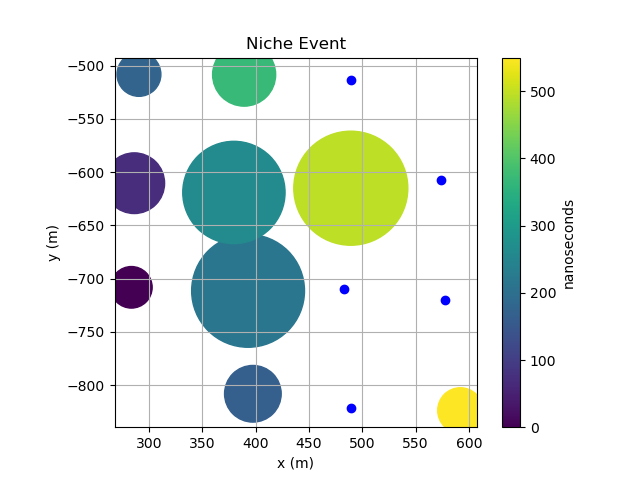

In [22]:
fitckv = get_ckv(fit_ev,cfg)
fit_nfits = pe.gen_nfits_from_ckv(fitckv)
plot_event(tyro(fit_nfits))

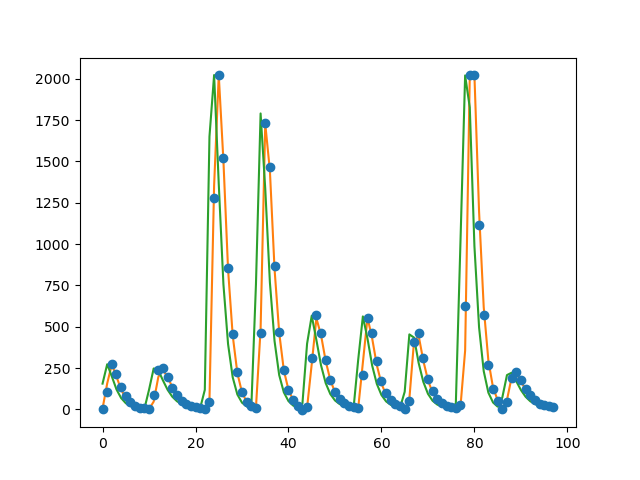

In [23]:
# at = AllTunka(real_nfits, BasicParams, cfg)
plt.figure()
plt.errorbar(np.arange(len(at.real_values)),at.real_values,yerr=at.error, fmt="o")
plt.plot(at.get_output(fitpars))
pars[-1] = fitpars[-1]
plt.plot(at.get_output(pars))
# plt.semilogy()

In [24]:
at.chi2(fitpars)/m.ndof

87.54198551713957

In [25]:
pars

[600.0,
 2000000.0,
 0.6981317007977318,
 3.490658503988659,
 450.0,
 -660.0,
 -29,
 0,
 70,
 -161.00228519985023]

In [26]:
at.error

array([1.77985695, 1.77985695, 1.77985695, 1.77985695, 1.77985695,
       1.77985695, 1.77985695, 1.77985695, 1.77985695, 1.77985695,
       3.86726447, 3.86726447, 3.86726447, 3.86726447, 3.86726447,
       3.86726447, 3.86726447, 3.86726447, 3.86726447, 3.86726447,
       3.86726447, 3.86726447, 3.80472111, 3.80472111, 3.80472111,
       3.80472111, 3.80472111, 3.80472111, 3.80472111, 3.80472111,
       3.80472111, 3.80472111, 3.80472111, 4.03359345, 4.03359345,
       4.03359345, 4.03359345, 4.03359345, 4.03359345, 4.03359345,
       4.03359345, 4.03359345, 4.03359345, 3.63691183, 3.63691183,
       3.63691183, 3.63691183, 3.63691183, 3.63691183, 3.63691183,
       3.63691183, 3.63691183, 3.63691183, 3.63691183, 3.63691183,
       2.72370277, 2.72370277, 2.72370277, 2.72370277, 2.72370277,
       2.72370277, 2.72370277, 2.72370277, 2.72370277, 2.72370277,
       2.56247274, 2.56247274, 2.56247274, 2.56247274, 2.56247274,
       2.56247274, 2.56247274, 2.56247274, 2.56247274, 2.56247

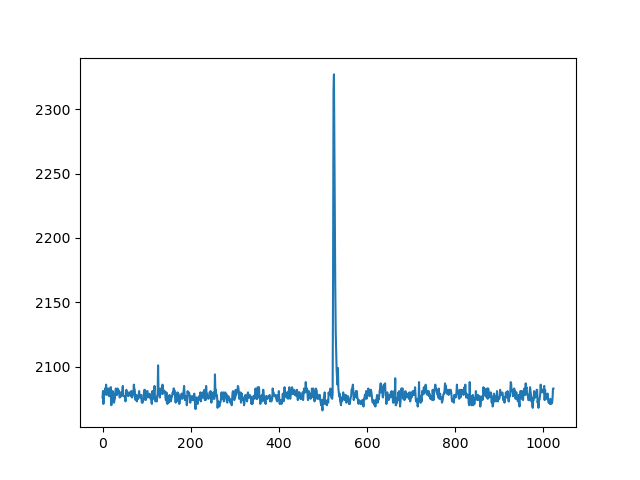

In [27]:
plt.figure()
plt.plot(real_nfits[1].waveform)

In [28]:
cfg.noise_open_files

[PosixPath('/home/isaac/niche_data/20230618/bardeen/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/bell/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/curie/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/feynman/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/newton/20230618050432.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/noether/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rossi/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rubin/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rutherford/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/wu/20230618050431.bg.bin')]

In [29]:
cfg.noise_closed_files

[PosixPath('/home/isaac/niche_data/20230618/bardeen/20230618050345.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/bell/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/curie/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/feynman/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/newton/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/noether/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rossi/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rubin/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rutherford/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/wu/20230618050344.bg.bin')]

In [30]:
real_nfits[0].name

'bardeen'